# Charting Boulder: Aging population
[Brian C. Keegan, Ph.D.](http://www.brianckeegan.com)  
August 2025

Released under a [MIT License](https://opensource.org/licenses/MIT).

### Import packages

In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_columns = 100

%matplotlib inline
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors

import geopandas as gpd

import json, requests

### Define generations

Definitions from [Pew Research Center](https://www.pewresearch.org/short-reads/2019/01/17/where-millennials-end-and-generation-z-begins/).

In [2]:
generation_def = {
    'Greatest':[1901,1927],
    'Silent':[1928,1945],
    'Boomer':[1946,1964],
    'GenX':[1965,1980],
    'Millennial':[1981,1996],
    'GenZ':[1997,2012],
    'Alpha':[2013,2024],
    'Beta':[2025,2040],
    'Gamma':[2041,2050],
}

# Labels for each age range
generation_order = ['Greatest','Silent','Boomer','GenX','Millennial','GenZ','Alpha','Beta','Gamma']

# Map colors to generations
generation_cmap = dict(zip(generation_order,mcolors.TABLEAU_COLORS.keys()))

# Map labels to each generation
generation_label = ['{0} ({1}–{2})'.format(_name,_start,_stop) for _name,[_start,_stop] in generation_def.items()]

# Map each birth year to a generation
generation_map = {}

for _name,[_start,_stop] in generation_def.items():
    for _year in range(_start,_stop+1):
        generation_map[_year] = _name

## Load State Demography Office data

From [State Demography Office](https://demography.dola.colorado.gov/assets/html/county.html).

In [3]:
# Load data
df = pd.read_excel('sya-county.xlsx',header=1)

# Cut data into age bins
df['age_bins'] = pd.cut(df['age'],[0,25,35,45,55,65,101],right=False)

# Calculate birth year based on current year and age
df['birthyear'] = df['year'] - df['age']
df['generation'] = df['birthyear'].map(generation_map)

# Filter to Colorado and Boulder County
co_df = df.copy()[df['county'] == 'Colorado']
boulder_df = df.copy()[df['county'] == 'Boulder']

# Map Census FIPS codes to county names
countyfips_dict = df[['countyfips','county']].drop_duplicates().set_index('countyfips')['county'].to_dict()
countyfips_dict[0] = 'Colorado'

df.head()

,id,countyfips,year,age,county,malepopulation,femalepopulation,totalpopulation,datatype,age_bins,birthyear,generation
0,1,0,1990,0,Colorado,26850,25695,52545,Estimate,"[0, 25)",1990,Millennial
1,2,0,1990,1,Colorado,25924,25081,51005,Estimate,"[0, 25)",1989,Millennial
2,3,0,1990,2,Colorado,25942,24659,50601,Estimate,"[0, 25)",1988,Millennial
3,4,0,1990,3,Colorado,26255,25106,51361,Estimate,"[0, 25)",1987,Millennial
4,5,0,1990,4,Colorado,26654,25556,52210,Estimate,"[0, 25)",1986,Millennial


## Load data from Boulder County Clerk

https://bouldercounty.gov/elections/maps-and-data/data-access/#Master-Voter-History-Data-File

The EX-002 data is updated every month and are moderate-sized files totally approximately 100MB unzipped.

In [39]:
# Load voter detail files
ex002_details_1_df = pd.read_csv(
    'EX-002_Public_Voter_Details_List_Part1.txt',
    dtype = {'VOTER_ID':str,'MAILING_ZIP_CODE':str,'PRECINCT_CODE':str,'PRECINCT_NAME':str},
    parse_dates = ['REGISTRATION_DATE','EFFECTIVE_DATE','LAST_UPDATED_DATE'],
    low_memory = False
)

ex002_details_2_df = pd.read_csv(
    'EX-002_Public_Voter_Details_List_Part2.txt',
    dtype = {'VOTER_ID':str,'MAILING_ZIP_CODE':str,'PRECINCT_CODE':str,'PRECINCT_NAME':str},
    parse_dates = ['REGISTRATION_DATE','EFFECTIVE_DATE','LAST_UPDATED_DATE'],
    low_memory = False
)

# Combine into single dataframe
ex002_details_df = pd.concat([ex002_details_1_df,ex002_details_2_df])

# Add boolean flag for over-65 voters
ex002_details_df['OVER_65'] = ex002_details_df['BIRTH_YEAR'] <= 1960

ex002_details_df.head()

,VOTER_ID,COUNTY,FIRST_NAME,MIDDLE_NAME,LAST_NAME,NAME_SUFFIX,REGISTRATION_DATE,EFFECTIVE_DATE,LAST_UPDATED_DATE,OLD_VOTER_ID,PHONE_NUM,HOUSE_NUM,HOUSE_SUFFIX,PRE_DIR,STREET_NAME,STREET_TYPE,POST_DIR,UNIT_TYPE,UNIT_NUM,RESIDENTIAL_ADDRESS,RESIDENTIAL_CITY,RESIDENTIAL_STATE,RESIDENTIAL_ZIP_CODE,RESIDENTIAL_ZIP_PLUS,MAILING_ADDRESS_1,MAILING_ADDRESS_2,MAILING_ADDRESS_3,MAILING_CITY,MAILING_STATE,MAILING_ZIP_CODE,MAILING_ZIP_PLUS,MAILING_COUNTRY,VOTER_STATUS,STATUS_REASON,PARTY,GENDER,BIRTH_YEAR,PRECINCT_CODE,PRECINCT_NAME,Federal,Congressional,Statewide,State Board of Education - At Large,State Board of Education,University of Colorado Regents - At Large,University of Colorado Regents,State Senate,State House,Judicial,Consolidated Regional Transportation,Regional Transportation,County Commissioner,Countywide,Municipality,City Ward/District,School,Conservation,Downtown Development Authority,Drainage and Flood Control,Fire Protection,Fire Protection 2,General Improvement,Library,Metropolitan,Miscellaneous General Improvement,Miscellaneous Other,Park and Recreation,Proposed,Proposed 2,Public Improvement,Public Improvement 2,Sanitation,Special Improvement,Urban Renewal/Reinvestment Authority,Water and Sanitation,Water Conservancy,Water Conservancy 3,Water,Water 2,Scientific Cultural Facilities,Front Range Passenger Rail,OVER_65
0,603027198,Boulder,ELIZABETH,REALE,WILEY,NaN,2021-07-20,2022-11-08,2024-11-27,NaN,NaN,313.0,NaN,NaN,CARIBOU PASS,CIR,NaN,NaN,NaN,313 CARIBOU PASS CIR,LAFAYETTE,CO,80026,NaN,313 CARIBOU PASS CIR,NaN,NaN,LAFAYETTE,CO,80026,NaN,NaN,Active,Failed to Vote,UAF,Female,1993,2171207314,2171207314,FED,2,CO,BE,2,UC,2,17,12,20,CRT,RTD I,NaN,7,LAFAYETTE,NaN,BVSD,NaN,NaN,64147.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64105.0,NaN,NaN,NaN,SCFD,FRPR,False
1,7954378,Boulder,EMILY,CARES,WALKER,NaN,2000-08-23,2024-01-05,2024-11-27,07-716204,NaN,3959.0,NaN,NaN,HAWTHORNE,CIR,NaN,NaN,NaN,3959 HAWTHORNE CIR,LONGMONT,CO,80503,NaN,3959 HAWTHORNE CIR,NaN,NaN,LONGMONT,CO,80503,NaN,NaN,Active,NaN,UAF,Female,1981,2171107608,2171107608,FED,2,CO,BE,2,UC,2,17,11,20,CRT,RTD O,NaN,7,LONGMONT,LMCW2,StVSD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64105.0,64133.0,NaN,NaN,SCFD,FRPR,False
2,8077707,Boulder,TERESA,KELLY,HAM,NaN,1997-06-16,2014-11-04,2024-11-27,07-642004,3036522578,6945.0,NaN,NaN,SPRINGHILL,DR,NaN,NaN,NaN,6945 SPRINGHILL DR,NIWOT,CO,80503,7121.0,6945 SPRINGHILL DR,NaN,NaN,NIWOT,CO,80503,7121.0,NaN,Active,NaN,UAF,Female,1979,2181207508,2181207508,FED,2,CO,BE,2,UC,2,18,12,20,CRT,RTD O,NaN,7,NaN,NaN,StVSD,64268.0,NaN,NaN,64087.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7034.0,NaN,NaN,NaN,64105.0,64133.0,64194.0,NaN,SCFD,FRPR,False
3,603802741,Boulder,ALYSIA,MARIE,MENDEZ,NaN,2024-09-20,2024-09-20,2025-04-24,NaN,9512271438,1038.0,NaN,NaN,DELTA,DR,NaN,APT,D,1038 DELTA DR APT D,LAFAYETTE,CO,80026,2895.0,1038 DELTA DR APT D,NaN,NaN,LAFAYETTE,CO,80026,2895.0,NaN,Active,NaN,DEM,Female,1997,2171207302,2171207302,FED,2,CO,BE,2,UC,2,17,12,20,CRT,RTD I,NaN,7,LAFAYETTE,NaN,BVSD,NaN,NaN,64147.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64105.0,NaN,NaN,NaN,SCFD,FRPR,False
4,602273312,Boulder,BRIAN,DAVID,OBERG,NaN,2020-03-03,2024-02-05,2024-11-27,NaN,NaN,740.0,NaN,NaN,DISCOVERY,PKWY,NaN,NaN,NaN,740 DISCOVERY PKWY,SUPERIOR,CO,80027,8736.0,740 DISCOVERY PKWY,NaN,NaN,SUPERIOR,CO,80027,8736.0,NaN,Active,NaN,DEM,Male,1970,2181207106,2181207106,FED,2,CO,BE,2,UC,2,18,12,20,CRT,RTD O,NaN,7,SUPERIOR,NaN,BVSD,NaN,NaN,64147.0,64087.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64105.0,NaN,NaN,NaN,SCFD,FRPR,False


Groupby-aggregate.

In [40]:
# Calculate number of over-65 and all voters per precinct
precinct_voter_age = ex002_details_df.groupby('PRECINCT_CODE').agg({'OVER_65':'sum','VOTER_ID':'nunique'})

# Percengage of over 65 voters among all current voters
precinct_voter_age['OVER_65_PCT'] = precinct_voter_age['OVER_65'] / precinct_voter_age['VOTER_ID']

precinct_voter_age.head()

,OVER_65,VOTER_ID,OVER_65_PCT
PRECINCT_CODE,,,
2151107703,71,200,0.355000
2151207700,534,1344,0.397321
2151907002,0,2,0.000000
2154907701,505,1357,0.372144
2154907702,260,675,0.385185


Load voting history data.

In [46]:
# Load voting history data
ex002_history_1_df = pd.read_csv(
    'EX-002_Public_Voting_History_List_Part1.txt',
    dtype = {'VOTER_ID':str},
    parse_dates = ['ELECTION_DATE'],
    low_memory = False
)

ex002_history_2_df = pd.read_csv(
    'EX-002_Public_Voting_History_List_Part2.txt',
    dtype = {'VOTER_ID':str},
    parse_dates = ['ELECTION_DATE'],
    low_memory = False
)

ex002_history_3_df = pd.read_csv(
    'EX-002_Public_Voting_History_List_Part3.txt',
    dtype = {'VOTER_ID':str},
    parse_dates = ['ELECTION_DATE'],
    low_memory = False
)

ex002_history_4_df = pd.read_csv(
    'EX-002_Public_Voting_History_List_Part4.txt',
    dtype = {'VOTER_ID':str},
    parse_dates = ['ELECTION_DATE'],
    low_memory = False
)

# Combine together
ex002_history_df = pd.concat([ex002_history_1_df,ex002_history_2_df,ex002_history_3_df,ex002_history_4_df])

# Drop rows with missing election description
ex002_history_df.dropna(subset=['ELECTION_DESCRIPTION'],inplace=True)
ex002_history_df.reset_index(drop=True,inplace=True)

# Filter to Boulder County voters
ex002_history_df = ex002_history_df[ex002_history_df['COUNTY_NAME'] == 'Boulder']

# Rename some election descriptions
ex002_history_df.replace(
    {'ELECTION_DESCRIPTION':{
        'General Election 2008':'2008 General Election',
        '2004 GENERAL ELECTION':'2004 General Election',
        '2006 GENERAL ELECTION':'2006 General Election',
        '2002 GENERAL ELECTION':'2002 General Election',
        '20001107':'2000 General Election',
    }
    },inplace=True)

# Extract year from election date
ex002_history_df['YEAR'] = ex002_history_df['ELECTION_DATE'].dt.year

# Print number of records
print("{0:,}".format(len(ex002_history_df)))

ex002_history_df.head()

3,149,246


,VOTER_ID,ELECTION_TYPE,ELECTION_DATE,ELECTION_DESCRIPTION,VOTING_METHOD,PARTY,COUNTY_NAME,YEAR
0,72491,General,2024-11-05,2024 Boulder County General Election,Mail Ballot,DEM,Boulder,2024
15,72491,Primary,2024-06-25,June 25 2024 Boulder County Election,Mail Ballot,DEM,Boulder,2024
16,72491,Primary,2024-03-05,2024 Boulder County Presidential Primary Election,Mail Ballot,DEM,Boulder,2024
21,72491,Coordinated,2023-11-07,2023 Boulder County Coordinated Election,Mail Ballot,DEM,Boulder,2023
28,72760,General,2024-11-05,2024 Boulder County General Election,Mail Ballot,UAF,Boulder,2024


In [56]:
# Filter to non-primary elections, only Boulder elections, and election years since 2010
c0 = ex002_history_df['ELECTION_TYPE'] != 'Primary'
c1 = ex002_history_df['ELECTION_DESCRIPTION'].str.contains('Boulder')
c2 = ex002_history_df['YEAR'] >= 2010

ex002_nonprimary_df = ex002_history_df[c0 & c1 & c2]

# Count the number of votes per election
ex002_nonprimary_df.groupby('ELECTION_DESCRIPTION').agg({'VOTER_ID':'nunique'})

,VOTER_ID
ELECTION_DESCRIPTION,
2010 Boulder County General Election,71914
2011 Boulder County Coordinated Election,49987
2012 Boulder County General Election,97394
2013 Boulder County Coordinated Election,66243
2014 Boulder County General Election,89871
2015 Boulder County Coordinated Election,59725
2016 Boulder County General Election,119914
2017 Boulder County Coordinated Election,69790
2018 Boulder County General Election,124926


## Load precinct map

Boulder County precinct shapefiles from [Boulder County Open Data](https://opendata-bouldercounty.hub.arcgis.com/datasets/c8e2897d283b47f780920af0827d5126_0/explore)

In [7]:
# Load file
precincts_gdf = gpd.read_file(
    'Precincts.geojson',
)

# Treat precincts as strings
precincts_gdf['PRECINCT'] = precincts_gdf['PRECINCT'].astype(str)
precincts_gdf = precincts_gdf.set_index('PRECINCT')

precincts_gdf.head()

,OBJECTID,DISTRICT,ABBREVIATI,EDIT_STAT,NOTES,SHAPEarea,SHAPElen,geometry
PRECINCT,,,,,,,,
2181207509,1,2181207509,509,None,None,3.781802e+07,32472.011805,"POLYGON ((-105.15943 40.1016, -105.15942 40.10..."
2151207700,2,2151207700,700,None,None,3.185796e+08,141376.521277,"POLYGON ((-105.13106 40.12712, -105.13105 40.1..."
2154907702,3,2154907702,702,None,None,4.708790e+08,132293.031420,"POLYGON ((-105.15906 40.26122, -105.15906 40.2..."
2154907701,4,2154907701,701,None,None,7.542485e+08,143186.276335,"POLYGON ((-105.23753 40.21215, -105.23759 40.2..."
2154907916,5,2154907916,916,None,None,4.107530e+08,129843.587911,"POLYGON ((-105.19594 40.26146, -105.19971 40.2..."


In [8]:
# Join precincts with over-65 voter information
precincts_over65_gdf = precincts_gdf.join(
    other = precinct_voter_age,
    how = 'left'
)

# Check number of rows
print(len(precincts_gdf),len(precinct_voter_age),len(precincts_over65_gdf))

precincts_over65_gdf.head()

193 192 193


,OBJECTID,DISTRICT,ABBREVIATI,EDIT_STAT,NOTES,SHAPEarea,SHAPElen,geometry,OVER_65,VOTER_ID,OVER_65_PCT
PRECINCT,,,,,,,,,,,
2181207509,1,2181207509,509,None,None,3.781802e+07,32472.011805,"POLYGON ((-105.15943 40.1016, -105.15942 40.10...",640.0,1682.0,0.380499
2151207700,2,2151207700,700,None,None,3.185796e+08,141376.521277,"POLYGON ((-105.13106 40.12712, -105.13105 40.1...",534.0,1346.0,0.396731
2154907702,3,2154907702,702,None,None,4.708790e+08,132293.031420,"POLYGON ((-105.15906 40.26122, -105.15906 40.2...",261.0,676.0,0.386095
2154907701,4,2154907701,701,None,None,7.542485e+08,143186.276335,"POLYGON ((-105.23753 40.21215, -105.23759 40.2...",509.0,1358.0,0.374816
2154907916,5,2154907916,916,None,None,4.107530e+08,129843.587911,"POLYGON ((-105.19594 40.26146, -105.19971 40.2...",356.0,1274.0,0.279435


## Get data from FRED API

The Federal Reserve Bank of St. Louis maintains a large database of economic (finance, banking, business, macro-indicators, demography, trade, etc.) data called the Federal Reserve Economic Data, or "FRED". FRED has a REST API for interfacing with this database but you must register an account with your email and request an API key for an application. Here is the [documentation](https://fred.stlouisfed.org/docs/api/fred/) for the API as well.

### Sign up and login
Go to `https://fredaccount.stlouisfed.org/`, click the "Register" button under "Want to create a new account?", enter your email or "Sign in with Google". 

![](fred_signup.png)

Click the "Request API Key" button and fill out the simple form with a basic description (e.g., "Exploratory data analyses for a web data scraping class"), and consent to the agreements. The API key should appear immediately. Write the key to a JSON file and then read the file into your notebook.

In [9]:
# This won't work unless you've made your own API key file
with open('fred_api.json','r') as f:
    fred_json = json.load(f)

if 'key' in fred_json:
    fred_key = fred_json['key']

We will use the annual consumer expenditure data segmented by age available from 1984 through 2023:

* Under 25: [CXUTOTALEXPLB0402M](https://fred.stlouisfed.org/series/CXUTOTALEXPLB0402M)
* 25 - 34: [CXUTOTALEXPLB0403M](https://fred.stlouisfed.org/series/CXUTOTALEXPLB0403M)
* 35 - 44: [CXUTOTALEXPLB0404M](https://fred.stlouisfed.org/series/CXUTOTALEXPLB0404M)
* 45 - 54: [CXUTOTALEXPLB0405M](https://fred.stlouisfed.org/series/CXUTOTALEXPLB0405M)
* 55 - 64: [CXUTOTALEXPLB0406M](https://fred.stlouisfed.org/series/CXUTOTALEXPLB0406M)
* 65 and over: [CXUTOTALEXPLB0407M](https://fred.stlouisfed.org/series/CXUTOTALEXPLB0407M)
* 65 - 74: [CXUTOTALEXPLB0408M](https://fred.stlouisfed.org/series/CXUTOTALEXPLB0408M)
* 75 and over: [CXUTOTALEXPLB0409M](https://fred.stlouisfed.org/series/CXUTOTALEXPLB0409M)

In [10]:
def retrieve_fred_obs(fred_key,series_id):
    # Define the API endpoint
    fred_api_endpoint = 'https://api.stlouisfed.org/fred'
    
    # Define the API tool to use
    fred_api_tool = '/series/observations'
    
    # Create a parameter dictionary based on API documentation
    param_d = {}
    param_d['series_id'] = series_id
    param_d['api_key'] = fred_key
    param_d['file_type'] = 'json'
    
    # Make the request
    fred_query = requests.get(
    url = fred_api_endpoint + fred_api_tool,
    params = param_d
    )
    
    if 'observations' in fred_query.json():
        return fred_query.json()['observations']

retrieve_fred_obs(fred_key,'CXUTOTALEXPLB0402M')[:5]

[{'realtime_start': '2025-08-20',
  'realtime_end': '2025-08-20',
  'date': '1984-01-01',
  'value': '13461'},
 {'realtime_start': '2025-08-20',
  'realtime_end': '2025-08-20',
  'date': '1985-01-01',
  'value': '13763'},
 {'realtime_start': '2025-08-20',
  'realtime_end': '2025-08-20',
  'date': '1986-01-01',
  'value': '14142'},
 {'realtime_start': '2025-08-20',
  'realtime_end': '2025-08-20',
  'date': '1987-01-01',
  'value': '14368'},
 {'realtime_start': '2025-08-20',
  'realtime_end': '2025-08-20',
  'date': '1988-01-01',
  'value': '16373'}]

Retrieve for all six series.

In [11]:
series_ids = ['CXUTOTALEXPLB0{0}M'.format(i) for i in range(402,410)]

series_d = {}

for s in series_ids:
    series_d[s] = retrieve_fred_obs(fred_key,s)

## Plot consumer expenditures by age

In [12]:
# Concatenate age ranges together
series_s_concat = {}
for s,d in series_d.items():
    series_s_concat[s] = pd.Series({pd.to_datetime(i['date']):pd.to_numeric(i['value']) for i in d})

expenditures_df = pd.concat(series_s_concat,axis=1)
expenditures_df.columns = ['Under 25','25-34','35-44','45-54','55-64','Over 65','65-74','Over 75']

expenditures_df.head()

,Under 25,25-34,35-44,45-54,55-64,Over 65,65-74,Over 75
1984-01-01,13461,22294,28214,28696,23401,NaN,15842,11122
1985-01-01,13763,23349,29604,30946,24766,NaN,17938,13012
1986-01-01,14142,23931,31219,32218,24808,NaN,17506,12198
1987-01-01,14368,24177,31473,31708,25707,NaN,18888,12230
1988-01-01,16373,25770,33078,33205,25765,17297.0,20120,13339


<Axes: >

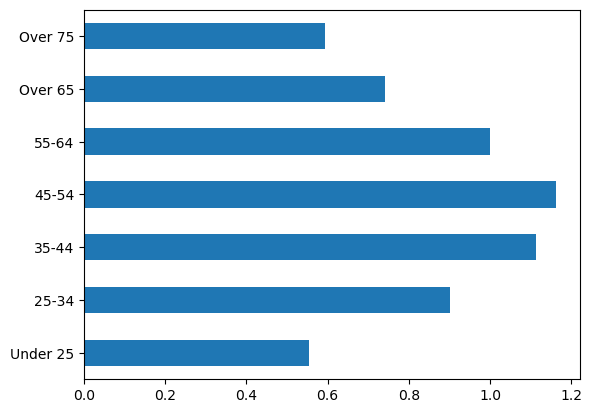

In [13]:
# Take average of expenditures for 1984 to present
mean_expenditures_df = expenditures_df.mean()

# Normalize by 55-64 values
mean_norm_expenditures_df = mean_expenditures_df / mean_expenditures_df.loc['55-64']

((mean_norm_expenditures_df - 1) * 100).to_clipboard()

mean_norm_expenditures_df[['Under 25','25-34','35-44','45-54','55-64','Over 65','Over 75']].plot.barh()

## Plot population by age cohort


In [14]:
# Make a pivot table of number of people by age bin, county, and year
pivot_df = pd.pivot_table(
    data = df,
    index = ['county','year',],
    columns = 'age_bins',
    values = 'totalpopulation',
    aggfunc = 'sum',
    observed = False
)

# Rename columns
age_buckets = ['0 – 24','25 – 34','35 – 44','44 – 54','55 – 64','65+']
pivot_df.columns = age_buckets

# Copy Boulder data
pivot_df.loc['Boulder',age_buckets].to_clipboard()

pivot_df['Total'] = pivot_df.sum(1)

pivot_df.loc['Boulder',age_buckets].head()

,0 – 24,25 – 34,35 – 44,44 – 54,55 – 64,65+
year,,,,,,
1990,85280,44286,42181,22990,14029,17256
1991,86743,44232,42801,24904,14630,17667
1992,89201,44807,43915,26862,15339,18268
1993,92180,45597,45286,29064,16165,18990
1994,93860,45706,46005,30933,16777,19445


<Axes: xlabel='year'>

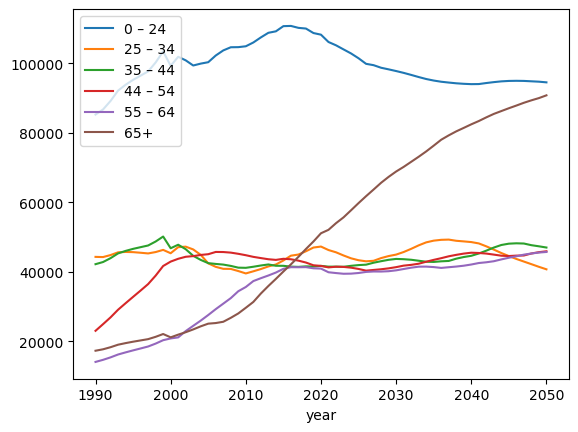

In [15]:
pivot_df.loc['Boulder',age_buckets].plot()

## Plot population by generation

In [16]:
# Make a pivot table of number of people by county, year, and generation
generation_pivot_df = pd.pivot_table(
    data = df,
    index = ['county','year'],
    columns = 'generation',
    values = 'totalpopulation',
    aggfunc = 'sum',
    observed = False
)

# Reorder columns
generation_pivot_df = generation_pivot_df[generation_order]

# Copy Boulder data
generation_pivot_df.loc['Boulder',:].to_clipboard()

generation_pivot_df.loc['Boulder',:].head()

generation,Greatest,Silent,Boomer,GenX,Millennial,GenZ,Alpha,Beta,Gamma
year,,,,,,,,,
1990,19023.0,34581.0,82677.0,57745.0,31325.0,NaN,NaN,NaN,NaN
1991,18891.0,35136.0,82291.0,60092.0,34567.0,NaN,NaN,NaN,NaN
1992,18268.0,35608.0,82936.0,63255.0,38325.0,NaN,NaN,NaN,NaN
1993,17694.0,35963.0,84316.0,66862.0,42447.0,NaN,NaN,NaN,NaN
1994,16902.0,35882.0,83924.0,69835.0,46183.0,NaN,NaN,NaN,NaN


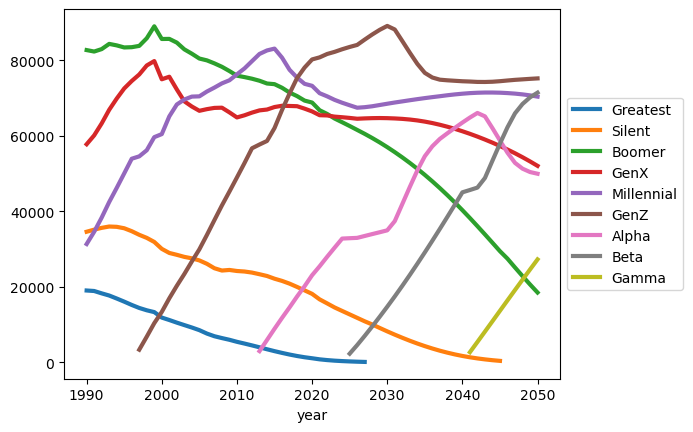

In [17]:
ax = generation_pivot_df.loc['Boulder',:].plot(lw=3)
ax.legend(loc='center left',bbox_to_anchor=(1,.5))

## Over-65 voters composition

In [35]:
# Make a pivot table of people over 65 by county, year, and generation
over65_comp_pivot_df = pd.pivot_table(
    data = df[df['age'] >= 65],
    index = ['county','year'],
    columns = 'generation',
    values = 'totalpopulation',
    aggfunc = 'sum',
    observed = False
)

# Reorder columns
over65_comp_pivot_df = over65_comp_pivot_df.loc[:,['Greatest','Silent','Boomer','GenX','Millennial']]

# Copy to clipboard
over65_comp_pivot_df.loc['Boulder',:].to_clipboard()

over65_comp_pivot_df.loc['Boulder',:].head()

generation,Greatest,Silent,Boomer,GenX,Millennial
year,,,,,
1990,16585.0,NaN,NaN,NaN,NaN
1991,17667.0,NaN,NaN,NaN,NaN
1992,18268.0,NaN,NaN,NaN,NaN
1993,17694.0,1296.0,NaN,NaN,NaN
1994,16902.0,2543.0,NaN,NaN,NaN


<Axes: xlabel='year'>

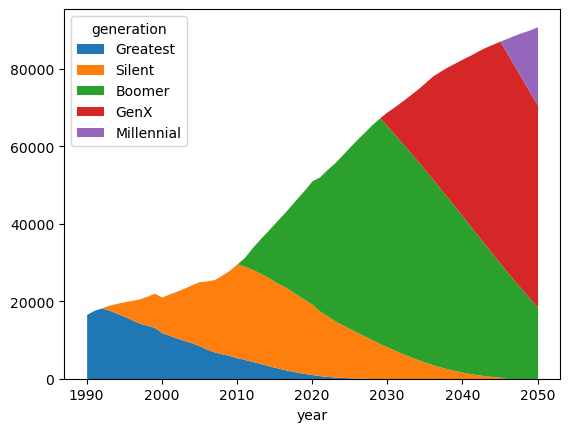

In [36]:
over65_comp_pivot_df.loc['Boulder',:].plot.area(stacked=True,lw=0)

## Plot over-65 voters

<Axes: >

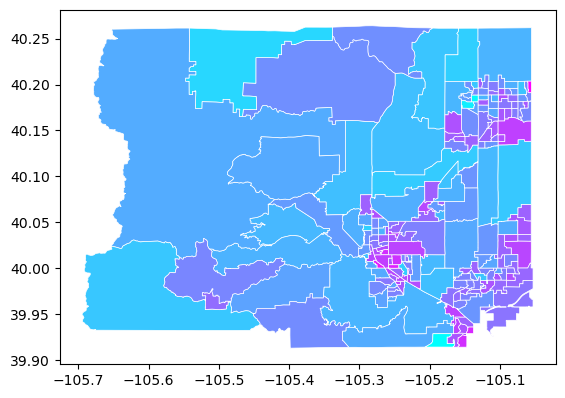

In [18]:
# Make a GeoPandas dataframe for precincts and over-65 percentage
precincts_over_65_export = precincts_over65_gdf.reset_index().set_index('OBJECTID')[['PRECINCT','OVER_65_PCT']]

precincts_over_65_export['OVER_65_PCT'] = (precincts_over_65_export['OVER_65_PCT'] * 100).round(2)

precincts_over_65_export.to_clipboard()

precincts_over65_gdf.plot('OVER_65_PCT',lw=.5,edgecolor='white',cmap='cool_r')

## Voting patterns by age

In [58]:
# Make a pivot table of whether each voter-id cast a ballot by year
recent_voting_pivot = pd.pivot_table(
    data = ex002_nonprimary_df,
    index = 'VOTER_ID',
    columns = 'YEAR',
    values = 'VOTING_METHOD',
    aggfunc = lambda x: len(list(x))
).fillna(0)

_df = ex002_details_df.set_index('VOTER_ID')

# Differentiate voters who were registered and didn't vote
# from voters who didn't vote because they weren't yet registered

for voter in recent_voting_pivot.index:
    reg_year = _df.loc[voter,'REGISTRATION_DATE'].year
    recent_voting_pivot.loc[voter,:reg_year-1] = np.nan
    
recent_voting_pivot.head()

YEAR,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
VOTER_ID,,,,,,,,,,,,,,,
1001523,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
1002603,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
1005829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
100606,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
101319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0


In [69]:
# Reshape data from "wide" to "long" and rename columns
recent_voting_pivot_stacked = recent_voting_pivot.stack().reset_index()
recent_voting_pivot_stacked.columns = ['VOTER_ID','ELECTION_YEAR','VOTED']

# Join in voter details for long ballot history
voter_details_long_df = pd.merge(
    left = ex002_details_df[['VOTER_ID','GENDER','BIRTH_YEAR','PRECINCT_CODE','REGISTRATION_DATE']],
    right = recent_voting_pivot_stacked,
    left_on = 'VOTER_ID',
    right_on = 'VOTER_ID',
    how = 'right'
)

# Calculate age of voter in each election
voter_details_long_df['AGE'] = voter_details_long_df['ELECTION_YEAR'] - voter_details_long_df['BIRTH_YEAR']
voter_details_long_df['AGE_CUT'] = pd.cut(
    x = voter_details_long_df['AGE'],
    bins = [18,25,35,45,55,65,110],
    right = False,
    labels = ['18-24','25-34','35-44','45-54','55-64','65+']
)

# Categorize elections as odd or even-year elections
voter_details_long_df['CYCLE'] = voter_details_long_df['ELECTION_YEAR'] % 2
voter_details_long_df.replace({'CYCLE':{1:'Odd',0:'Even'}},inplace=True)

voter_details_long_df.head()

,VOTER_ID,GENDER,BIRTH_YEAR,PRECINCT_CODE,REGISTRATION_DATE,ELECTION_YEAR,VOTED,AGE,AGE_CUT,CYCLE
0,1001523,Female,1974,2171907620,2009-11-13,2010,0.0,36,35-44,Even
1,1001523,Female,1974,2171907620,2009-11-13,2011,0.0,37,35-44,Odd
2,1001523,Female,1974,2171907620,2009-11-13,2012,0.0,38,35-44,Even
3,1001523,Female,1974,2171907620,2009-11-13,2013,0.0,39,35-44,Odd
4,1001523,Female,1974,2171907620,2009-11-13,2014,1.0,40,35-44,Even


In [88]:
# Groupby by election year, cycle type, and age group and calculate number of ballots and voters
turnout_df = voter_details_long_df.groupby(['ELECTION_YEAR','CYCLE','AGE_CUT'],observed=False).agg({'VOTED':'sum','VOTER_ID':'nunique'})

# Calculate turnout as voted divided by all voters
turnout_df['TURNOUT'] = turnout_df['VOTED'] / turnout_df['VOTER_ID']

turnout_df.reset_index(inplace=True)

# Reshape data into columns as age buckets, rows as odd vs. even year elections, and values as average turnout
_df = turnout_df.groupby(['AGE_CUT','CYCLE'],observed=False).agg({'TURNOUT':'mean'})['TURNOUT'].unstack(0)
    
_df.to_clipboard()

_df.head()

AGE_CUT,18-24,25-34,35-44,45-54,55-64,65+
CYCLE,,,,,,
Even,0.687010,0.753228,0.853057,0.896718,0.929627,0.955935
Odd,0.246562,0.341697,0.467801,0.555580,0.670731,0.804205


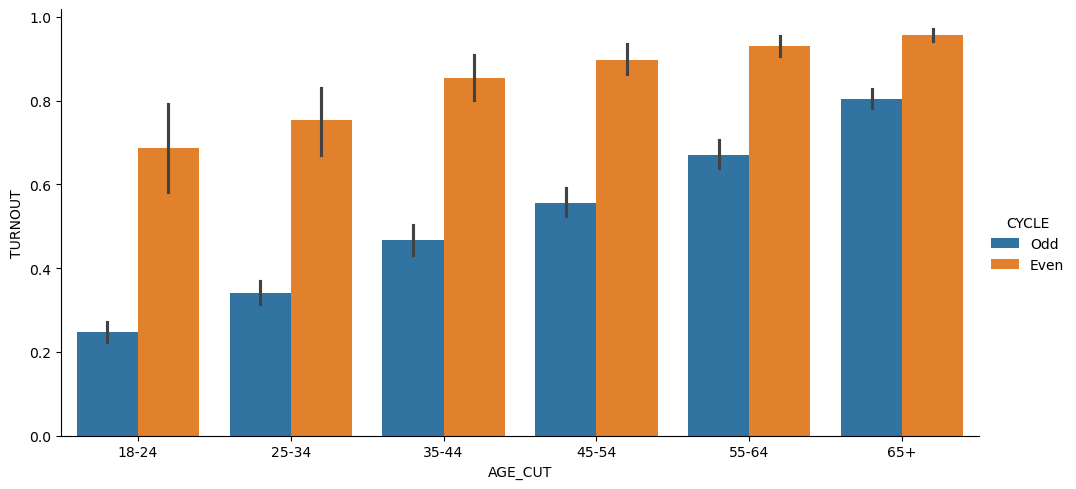

In [73]:
g = sb.catplot(
    data = turnout_df,
    x = 'AGE_CUT',
    y = 'TURNOUT',
    hue = 'CYCLE',
    hue_order = ['Odd','Even'],
    kind = 'bar',
    palette = 'tab10',
    aspect = 2,
    dodge = .5
)